In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_root = "/home/jturner/false_low_clouds_2023/Model/Model_flc_v2_data/"

In [3]:
time="00z"

date="20230907"

Import the GFS and SST data

*capture just withholds the output*

In [4]:
%%capture
gfs_file = data_root+"time_"+time+"/"+date+"/gfs.t"+time+".pgrb2.0p25.f000"

gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib", backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

In [5]:
sst_file = data_root+"time_"+time+"/"+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

Filter the datasets to the region of interest

In [6]:
#---Georges Bank
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

In [7]:
sst_ds = sst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))

#--- GFS data latitude is reversed compared to the SST data, this flips it into position.
gfs_ds = gfs_ds.sel(latitude=slice(None, None, -1))

gfs_ds = gfs_ds.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon+360,max_lon+360))

For atmospheric temperature, use from the level of most humidity

Identify the indices where the maximum humidity occurs for each height level

In [8]:
max_humidity_indices = gfs_ds['q'].argmax(dim='isobaricInhPa')

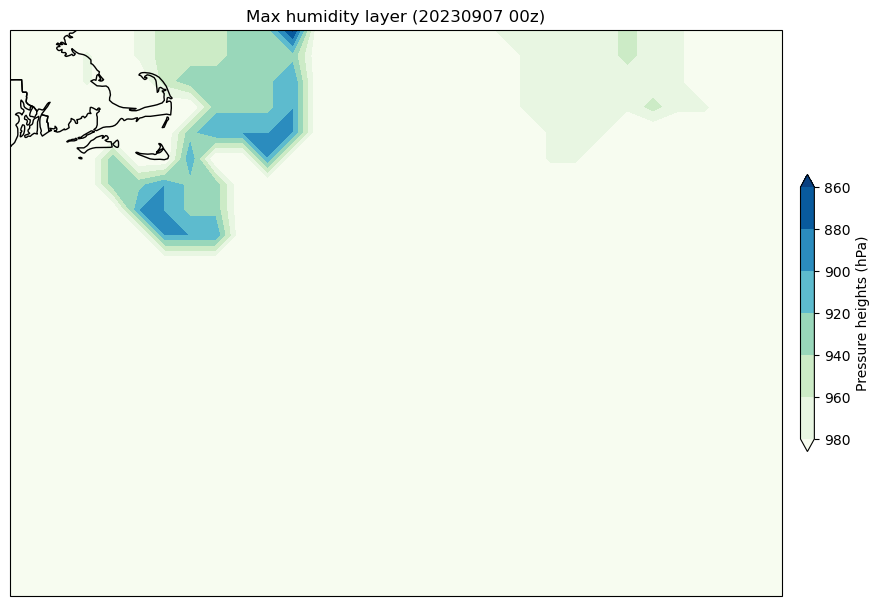

In [9]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.GnBu_r

pressure_heights = gfs_ds['isobaricInhPa'].isel(isobaricInhPa=max_humidity_indices)

c=ax.contourf(max_humidity_indices.longitude, max_humidity_indices.latitude, pressure_heights, cmap=cmap, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Max humidity layer ('+date+' '+ time+')')
clb.set_label('Pressure heights (hPa)')
clb.ax.invert_yaxis()

ax.add_feature(cfeature.STATES)

Use these indices to filter the temperature data

In [10]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = gfs_ds.t.values[0][0:begin,0:end]

In [11]:
#---For some bizarre reason, this initialization of T_maxq seems to be necessary
#---Another bizarre action is that this changes dims to a numpy array
T_maxq = np.zeros(dims.shape)
T_maxq = gfs_ds['t'].isel(isobaricInhPa=max_humidity_indices)

In [12]:
T_diff = T_maxq[0:begin,0:end].values - sst_ds.sst[:,:].values

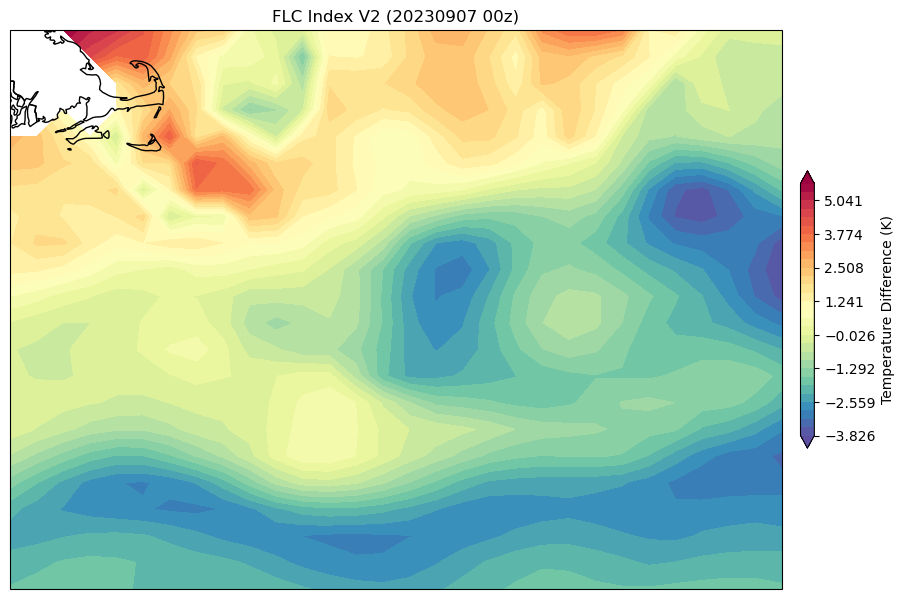

In [13]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(np.nanmin(T_diff), np.nanmax(T_diff), 31)

c=ax.contourf(sst_ds.lon, sst_ds.lat, T_diff, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index V2 ('+date+' '+ time+')')
clb.set_label('Temperature Difference (K)')

ax.add_feature(cfeature.STATES)

## FLCI data created with Model_flc_v2_data/data_download.sh

In [16]:
root = "/home/jturner/false_low_clouds_2023/Model/Model_flc_v2_data/"
time="00z"
date="20230908"
region="Georges_Bank"

In [20]:
data = xr.open_dataset(root+'/time_'+time+'/'+region+'/'+date+'.nc')

In [21]:
data

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 30)
Coordinates:
  * lat      (lat) float32 37.12 37.38 37.62 37.88 ... 41.62 41.88 42.12 42.38
  * lon      (lon) float32 288.6 288.9 289.1 289.4 ... 295.1 295.4 295.6 295.9
Data variables:
    t_diff   (lat, lon) float64 ...

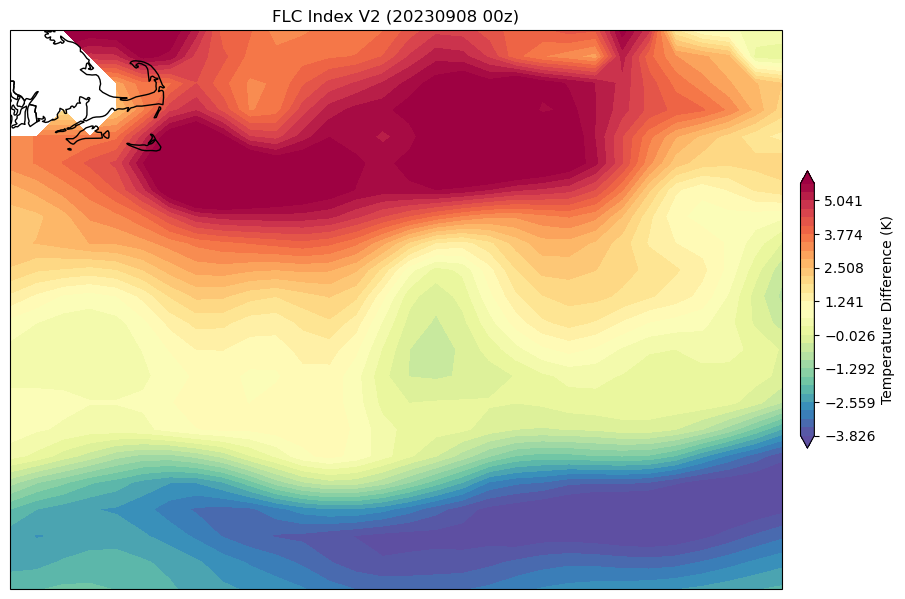

In [22]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(np.nanmin(T_diff), np.nanmax(T_diff), 31)

c=ax.contourf(data.lon, data.lat, data.t_diff, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index V2 ('+date+' '+ time+')')
clb.set_label('Temperature Difference (K)')

ax.add_feature(cfeature.STATES)